In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

import jax
import jax.numpy as jnp
from jax import vmap

### Documentation

scipy.optimize.`root`(fun, x0, args=(), method='hybr', jac=None, tol=None, callback=None, options=None)

`funcallable`
A vector function to find a root of.

`x0ndarray`
Initial guess.

`argstuple`, optional
Extra arguments passed to the objective function and its Jacobian.

`methodstr`, optional

### Second-order Collocation in Numpy

In [2]:
def quadratic_collocation(f, t_bounds, y_bounds, collocation_points):
    """
    Solves a second-order ODE using the collocation method with a quadratic polynomial.

    Args:
        f (function): The second-order ODE function of the form f(t).
        t_bounds (tuple): The boundary values for t (t0, t1).
        y_bounds (tuple): The boundary values for y (y0, y1).
        collocation_points (list): List of collocation points in the interval (t0, t1).

    Returns:
        function: The polynomial approximation u(t).
    """
    t0, t1 = t_bounds
    y0, y1 = y_bounds

    # number of collocation points
    n = len(collocation_points)
    
    # polynomial basis functions
    def basis_function1(t): return 1
    def basis_function2(t): return t
    def basis_function3(t): return t**2
    
    # derivatives of basis functions
    
    def  second_derivative1(t): return 0
    def  second_derivative2(t): return 0
    def  second_derivative3(t): return 2
    
    def equations(coeffs):
        """
        Defines the system of equations for the collocation method to solve a second-order ODE
        """
        x1, x2, x3 = coeffs
        
        # evaluate at the boundary conditions: u(t0) = y0, u(t1) = y1
        eq1 = x1 * basis_function1(t0) + x2 * basis_function2(t0) + x3 * basis_function3(t0) - y0
        eq2 = x1 * basis_function1(t1) + x2 * basis_function2(t1) + x3 * basis_function3(t1) - y1
        
        # collocation conditions
        collocation_eqs = []
        for c_pt in collocation_points:
            # collocation equation for u''(t) 
            collocation_eq = x1 *  second_derivative1(c_pt) + x2 *  second_derivative2(c_pt) + x3 *  second_derivative3(c_pt) - f(c_pt)
            collocation_eqs.append(collocation_eq)
        
        result = np.concatenate(([eq1, eq2], collocation_eqs)) 
        # print(result)
        return result
    
    # initial guess for the coefficients
    initial_guess = [0, 0, 0]
    
    # solve for the coefficients using scipy.optimize.root
    solution = root(equations, initial_guess)
    
    if not solution.success:
        raise RuntimeError("Root finding did not converge")
    
    x1, x2, x3 = solution.x
    
    # polynomial approximation
    def u(t):
        return x1 * basis_function1(t) + x2 * basis_function2(t) + x3 * basis_function3(t)
    
    return u

least square solver when more equations than unknowns = best fit

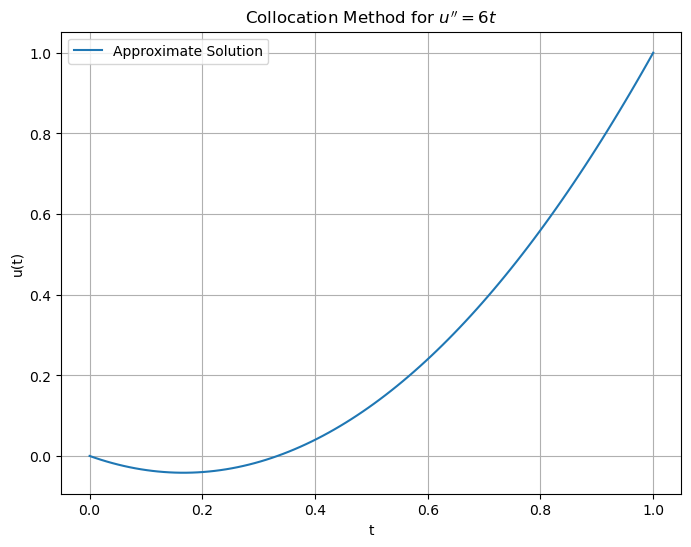

In [3]:
# define the ODE function f(t) = 6t to solve
def f(t):
    return 6 * t

# boundary values for t and y
t_bounds = (0, 1)
y_bounds = (0, 1)

# collocation points
collocation_points = [0.5]

# solve
u = quadratic_collocation(f, t_bounds, y_bounds, collocation_points)

# evaluate at 100 points 
t_vals = np.linspace(0, 1, 100)
u_vals = u(t_vals)

plt.figure(figsize=(8, 6))
plt.plot(t_vals, u_vals, label='Approximate Solution')
plt.title('Collocation Method for $u\'\' = 6t$')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()


### Generalized collocation with a polynomial

u'' = 6t;
u(0) = 0
u(1) = 1

u(t) = x1 + x2t + x3t**2

3t**2 + c

t**3 + c1t + c2

cubic polynomial; approximate qubic polynomial with quadratic polynomial

approximation goes to the solution when n (order of the polynomial = number of collocation points)

### JAX

Coefficients: [-2.33954311e-24 -6.92017897e-13 -8.03142561e-16  1.00000000e+00
 -6.71241838e-16]


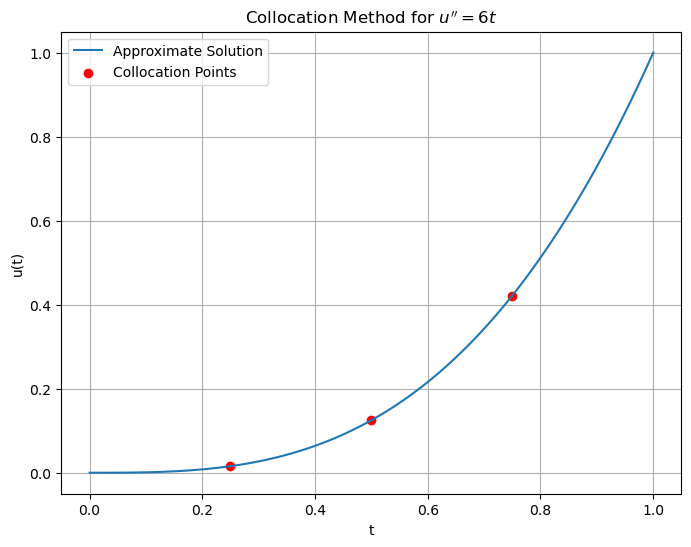

CPU times: user 583 ms, sys: 47.9 ms, total: 631 ms
Wall time: 512 ms


In [5]:
%%time
def basis_function(t, i):
    return t ** i

def second_derivative(t, i):
    if i < 2:
        return 0
    else:
        return i * (i - 1) * t ** (i - 2)
    
def collocation(f, t_bounds, y_bounds, collocation_points):
    """
    Solve a second-order ODE using the collocation method with a polynomial of degree n+1.

    Args:
        f (function): The second-order ODE function of the form f(t).
        t_bounds (tuple): The boundary values for t (t0, t1).
        y_bounds (tuple): The boundary values for y (y0, y1).
        collocation_points (list): List of collocation points in the interval (t0, t1).

    Returns:
        function: The polynomial approximation u(t).
    """
    t0, t1 = t_bounds
    y0, y1 = y_bounds
    n = len(collocation_points)
    
    # system of equations for the collocation method
    def equations(coeffs):
        # evaluate at the boundary conditions: u(t0) = y0, u(t1) = y1 for all of the collocation points
        # substitute t0 and t1 into the polynomial approximation => sum of coefficients * basis functions = y0, y1
        eq1 = sum(coeffs[i] * basis_function(t0, i) for i in range(n + 2)) - y0
        eq2 = sum(coeffs[i] * basis_function(t1, i) for i in range(n + 2)) - y1
        
        # collocation conditions
        collocation_eqs = []
        for c_pt in collocation_points:
            collocation_eq = sum(coeffs[i] *  second_derivative(c_pt, i) for i in range(n + 2)) - f(c_pt)
            collocation_eqs.append(collocation_eq)
        
        return jnp.concatenate([jnp.array([eq1, eq2]), jnp.array(collocation_eqs)], 0)
    
    # initial guess for the coefficients
    initial_guess = jnp.zeros(n + 2)
    
    # solve for the coefficients using scipy.optimize.root
    solution = root(lambda coeffs: np.array(equations(coeffs)), initial_guess)
    # result = root(lambda coeffs: jit(jacfwd(equations))(coeffs).block_until_ready(), coeffs_initial, method='hybr') ???
    
    if not solution.success:
        raise RuntimeError("Root finding did not converge")
    
    coeffs = solution.x
    
    # Polynomial approximation
    def u(t):
        return sum(coeffs[i] * basis_function(t, i) for i in range(n + 2))
    
    print(f"Coefficients: {coeffs}")
    return u

# ODE function u(t)'' = 6t 
def f(t):
    return 6 * t

# boundary values for t and y
t_bounds = (0, 1)
y_bounds = (0, 1)

#  collocation points
collocation_points = [0.25, 0.5, 0.75]

# solve
u = collocation(f, t_bounds, y_bounds, collocation_points)

# evaluate
t_vals = jnp.linspace(0, 1, 100)
u_vals = jax.vmap(u)(t_vals)

plt.figure(figsize=(8, 6))
plt.plot(t_vals, u_vals, label='Approximate Solution')
plt.scatter(collocation_points, jax.vmap(u)(jnp.array(collocation_points)), color='red', label='Collocation Points')
plt.title('Collocation Method for $u\'\' = 6t$')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()


Coefficients: [ 4.93038066e-32  4.00000000e+00 -3.00000000e+00 -5.26719478e-16
  2.10687791e-16]


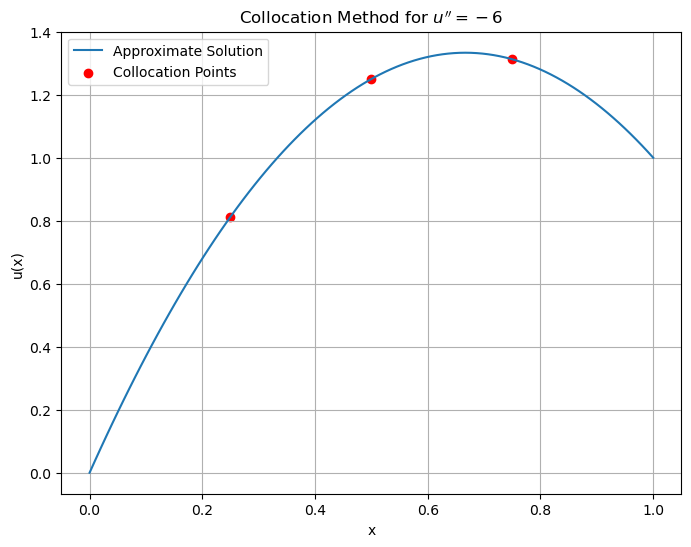

In [12]:
def basis_function(x, i):
    return x ** i

def second_derivative(x, i):
    if i < 2:
        return 0
    else:
        return i * (i - 1) * x ** (i - 2)
    
def collocation(f, x_bounds, u_bounds, collocation_points):
    x0, xL = x_bounds
    u0, uL = u_bounds
    n = len(collocation_points)
    
    # System of equations for the collocation method
    def equations(coeffs):
        # Boundary conditions
        eq1 = sum(coeffs[i] * basis_function(x0, i) for i in range(n + 2)) - u0
        eq2 = sum(coeffs[i] * basis_function(xL, i) for i in range(n + 2)) - uL
        
        # Collocation conditions
        collocation_eqs = [sum(coeffs[i] * second_derivative(c_pt, i) for i in range(n + 2)) - f(c_pt) for c_pt in collocation_points]
        
        return np.array([eq1, eq2] + collocation_eqs)
    
    # Initial guess for the coefficients
    initial_guess = np.zeros(n + 2)
    
    # Solve for the coefficients using scipy.optimize.root
    solution = root(lambda coeffs: equations(coeffs), initial_guess)
    
    if not solution.success:
        raise RuntimeError("Root finding did not converge")
    
    coeffs = solution.x
    
    # Polynomial approximation
    def u(x):
        return sum(coeffs[i] * basis_function(x, i) for i in range(n + 2))
    
    print("Coefficients:", coeffs)
    return u

# ODE function f(x) = -k (constant source term)
def f(x):
    k = -6  # Example constant
    return k

# Boundary values for x and u
x_bounds = (0, 1)
u_bounds = (0, 1)  # Example boundary temperatures

# Collocation points
collocation_points = [0.25, 0.5, 0.75]

# Solve
u = collocation(f, x_bounds, u_bounds, collocation_points)

# Evaluate
x_vals = np.linspace(0, 1, 100)
u_vals = np.vectorize(u)(x_vals)

plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_vals, label='Approximate Solution')
plt.scatter(collocation_points, np.vectorize(u)(np.array(collocation_points)), color='red', label='Collocation Points')
plt.title('Collocation Method for $u\'\' = -6$')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()


Coefficients X: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Coefficients Y: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


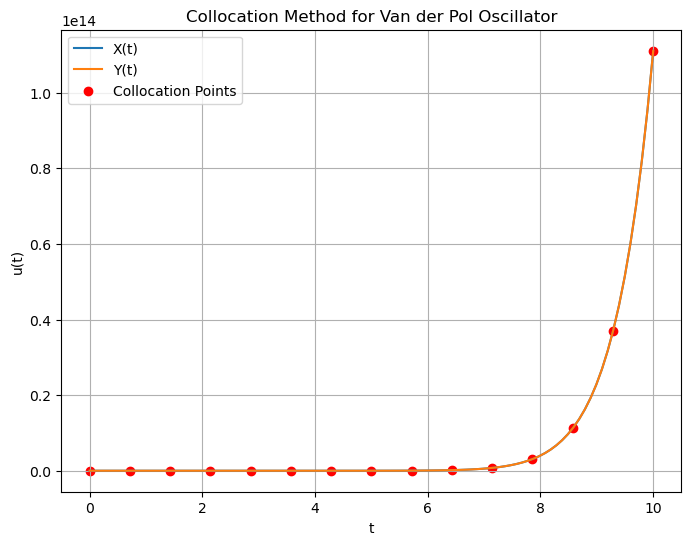

In [15]:
def vdp_oscillator(y, t, mu):
    """
    Defines the differential equations for the Van der Pol oscillator.
    dX/dt = Y
    dY/dt = mu * (1 - X^2) * Y - X
    Args:
        y (array-like): A 2-element array representing the state variables [X, Y].
        t (float): The current time.
        mu (float): The parameter mu that controls the non-linearity and the strength of the damping.

    Returns:
        array: A 2-element array containing the derivatives [dX/dt, dY/dt].
    """
    y1, y2 = y
    # array of derivatives dX/dt and dY/dt
    dydt = jnp.array([y2, mu * (1 - y1**2) * y2 - y1])
    return dydt


def collocation_vdp(ode_system, mu, t_bounds, y0, collocation_points):
    # upper and lower bounds for t
    t0, t1 = t_bounds
    # 
    X0, Y0 = y0
    n = len(collocation_points) # degree of the polynomial is number of points

    def equations(coeffs):
        # total number of coefficients is 2 * (n + 1)
        # split the coefficients into 2 halves for X and Y
        coeffs_X = coeffs[:n + 1]
        coeffs_Y = coeffs[n + 1:]

        # boundary conditions
        # t = t0
        eq1 = sum(coeffs_X[i] * basis_function(t0, i) for i in range(n + 1)) - X0
        eq2 = sum(coeffs_Y[i] * basis_function(t0, i) for i in range(n + 1)) - Y0
        # t = t1
        eq3 = sum(coeffs_X[i] * basis_function(t1, i) for i in range(n + 1)) - X0
        eq4 = sum(coeffs_Y[i] * basis_function(t1, i) for i in range(n + 1)) - Y0

        # collocation conditions
        collocation_eqs = []
        # for each collocation point construct the collocation equation
        for c_pt in collocation_points:
            # polynomial approximation at the collocation point (value of X(t) and Y(t) under the approx)
            u1 = sum(coeffs_X[i] * basis_function(c_pt, i) for i in range(n + 1))
            u2 = sum(coeffs_Y[i] * basis_function(c_pt, i) for i in range(n + 1))
            
            # first derivatives at the collocation points from the polynomial approximation
            du1_dt = sum(coeffs_X[i] * first_derivative(c_pt, i) for i in range(n + 1))
            du2_dt = sum(coeffs_Y[i] * first_derivative(c_pt, i) for i in range(n + 1))

            # pass into vdp_oscillator to get the derivatives [dX/dt, dY/dt]
            dy_dt = ode_system([u1, u2], c_pt, mu)
            
            collocation_eq1 = du1_dt - dy_dt[0] # dX/dt
            collocation_eq2 = du2_dt - dy_dt[1] # dY/dt

            collocation_eqs.append(collocation_eq1)
            collocation_eqs.append(collocation_eq2)
            
        # , eq3, eq4
        equ = jnp.concatenate([jnp.array([eq1, eq2]), jnp.array(collocation_eqs)])
        # print(len(equ))

        return equ

    # initial guess for the coefficients
    initial_guess = jnp.ones(2 * (n + 1)) * 0.1

    # solve for the coefficients using scipy.optimize.root
    solution = root(lambda coeffs: np.array(equations(coeffs)), initial_guess, method='lm', tol=1e-3)

    if not solution.success:
        raise RuntimeError("Root finding did not converge")

    coeffs = solution.x
    coeffs_X = coeffs[:n + 1]
    coeffs_Y = coeffs[n + 1:]

    # approximation
    u1 = lambda t: sum(coeffs_X[i] * basis_function(t, i) for i in range(n + 1))
    u2 = lambda t: sum(coeffs_Y[i] * basis_function(t, i) for i in range(n + 1))

    print(f"Coefficients X: {coeffs_X}")
    print(f"Coefficients Y: {coeffs_Y}")

    return u1, u2

mu = 1.0

# Boundary values for t and initial conditions
t_bounds = (0, 10)
# initial conditions for X(0) and Y(0)
y0 = [2.0, 0.0]

collocation_points = jnp.linspace(t_bounds[0], t_bounds[1], 15)

u1, u2 = collocation_vdp(vdp_oscillator, mu, t_bounds, y0, collocation_points)

# evaluate the approximate solution at several points
t_vals = jnp.linspace(t_bounds[0], t_bounds[1], 100)
u1_vals = vmap(u1)(t_vals)
u2_vals = vmap(u2)(t_vals)

# Plot the approximate solution
plt.figure(figsize=(8, 6))
plt.plot(t_vals, u1_vals, label='X(t)')
plt.plot(t_vals, u2_vals, label='Y(t)')
plt.scatter(collocation_points, vmap(u1)(collocation_points), color='red', label='Collocation Points')
plt.title('Collocation Method for Van der Pol Oscillator')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()


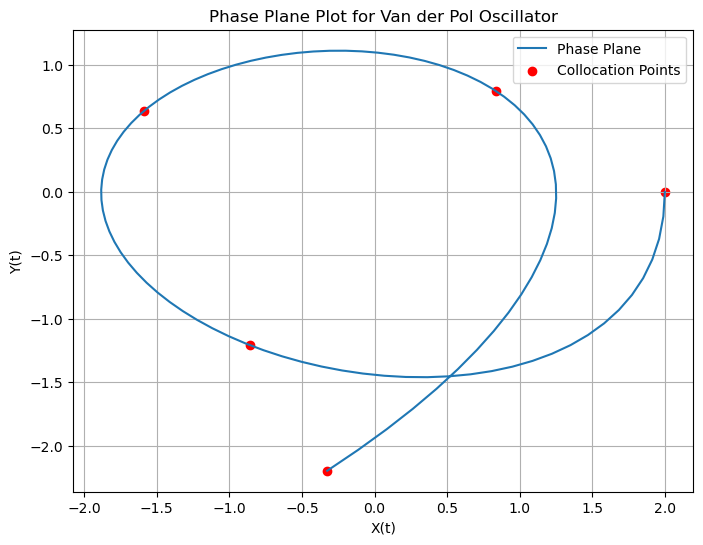

In [378]:
plt.figure(figsize=(8, 6))
plt.plot(u1_vals, u2_vals, label='Phase Plane')
plt.scatter(vmap(u1)(collocation_points), vmap(u2)(collocation_points), color='red', label='Collocation Points')
plt.title('Phase Plane Plot for Van der Pol Oscillator')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.legend()
plt.grid(True)
plt.show()

## Lagrange Interpolation

#### scipy example - unstable

In [379]:
from scipy.interpolate import lagrange
x = np.array([0, 1, 2])
f_x = x**3
poly = lagrange(x, f_x)
poly

poly1d([ 3., -2.,  0.])

## Simple Example of Largrange interpolation

### Lagrange basis *l_i(x)* used in the Lagrange interpolation polynomial

In [17]:
def lagrange_basis(x, x_i, i):
    """
    Compute the i-th Lagrange basis (l_i(x))
    """
    # for each x_i
    n = len(x_i)
    l_i = 1
    for j in range(n):
        if j != i:
            # compute the product
            l_i *= (x - x_i[j]) / (x_i[i] - x_i[j])
    return l_i

### Interpolation of a single value

In [18]:
def lagrange_interpolation(x, x_i, y_i):
    """
    Compute the Lagrange interpolation polynomial at x
    
    Parameters:
    x: Point at which to evaluate the polynomial
    x_i: Array of x coordinates of the known data points
    y_i: Array of y coordinates of the known data points
    
    Returns:
    Interpolated value at x
    """
    n = len(x_i)
    p_x = 0
    for i in range(n):
        p_x += y_i[i] * lagrange_basis(x, x_i, i)
    return p_x

In [33]:
x_i = jnp.array([0.0, 1.0, 2.0, 3.0])
y_i = jnp.array([1.0, 2.0, 0.0, -1.0])
x = 1.5

interpolated_value = lagrange_interpolation(x, x_i, y_i)
print(f"Interpolated value at x={x}: {interpolated_value}")

Interpolated value at x=1.5: 1.125


Each $\ell_i$, Lagrange basis, can be obtained through a general formula:
$$
\ell_i(x) = \prod_{\substack{j=0 \\ j \ne i}}^n \frac{x - x_j}{x_i - x_j} \quad (0 \le i \le n)
$$


In [37]:
import sympy as sp

def print_lagrange_coefficients(x_nodes, y_nodes):
    """Prints the coefficients of the Lagrange interpolation polynomial."""
    x = sp.symbols('x')
    n = len(x_nodes)
    polynomial = 0

    for i in range(n):
        term = y_nodes[i]
        # multiply by the basis polynomial for the i-th term
        for j in range(n):
            if i != j:
                term *= ((x - x_nodes[j]) / (x_nodes[i] - x_nodes[j]))
                print(term)
        
        polynomial += term

    print("Lagrange polynomial:", polynomial)
    polynomial = sp.expand(polynomial)
    print("Lagrange polynomial:", polynomial)
    # extract the coefficients
    coeffs = polynomial.as_poly().all_coeffs()

    print("Coefficients of the polynomial:", coeffs)
    
print_lagrange_coefficients(x_i, y_i)

1.0 - 1.0*x
(1.0 - 1.0*x)*(1.0 - 0.5*x)
(1.0 - 1.0*x)*(1.0 - 0.5*x)*(1.0 - 0.333333333333333*x)
2.0*x
2.0*x*(2.0 - 1.0*x)
2.0*x*(1.5 - 0.5*x)*(2.0 - 1.0*x)
0
0
0
-0.333333333333333*x
-0.333333333333333*x*(0.5*x - 0.5)
-0.333333333333333*x*(0.5*x - 0.5)*(1.0*x - 2.0)
Lagrange polynomial: 2.0*x*(1.5 - 0.5*x)*(2.0 - 1.0*x) - 0.333333333333333*x*(0.5*x - 0.5)*(1.0*x - 2.0) + (1.0 - 1.0*x)*(1.0 - 0.5*x)*(1.0 - 0.333333333333333*x)
Lagrange polynomial: 0.666666666666667*x**3 - 3.5*x**2 + 3.83333333333333*x + 1.0
Coefficients of the polynomial: [0.666666666666667, -3.50000000000000, 3.83333333333333, 1.00000000000000]


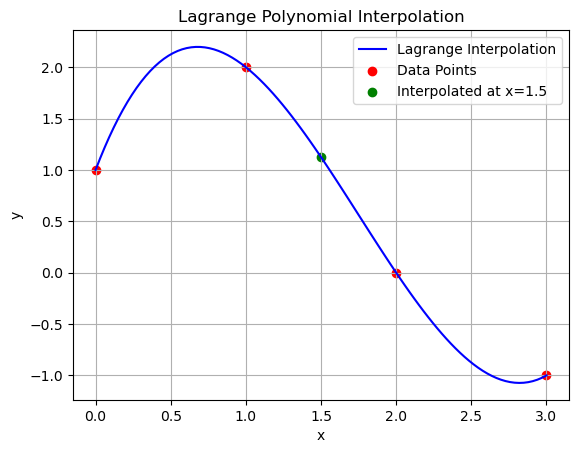

In [30]:
fig, ax = plt.subplots()
x_vals = jnp.linspace(0, 3, 100)
y_vals = jnp.array([lagrange_interpolation(xi, x_i, y_i) for xi in x_vals])

ax.plot(x_vals, y_vals, label='Lagrange Interpolation', color='blue')

ax.scatter(x_i, y_i, color='red', label='Data Points')
ax.scatter(x, interpolated_value, color='green', label=f'Interpolated at x={x}')

ax.grid(True)
ax.set_title('Lagrange Polynomial Interpolation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()

### Moving towards collocation using Lagrange Interpolation

In [383]:
def lagrange_basis(t, i, collocation_points):
    """
    Compute the i-th Lagrange basis (l_i(t)) at point t.
    
    Args:
        t (float): The point at which to evaluate the Lagrange basis polynomial.
        i (int): The index of the Lagrange basis polynomial.
        collocation_points (list): The list of collocation points.

    Returns:
        float: The value of the i-th Lagrange basis polynomial at point t.
    """
    x_i = collocation_points[i]
    basis_poly = 1.0
    for j, x_j in enumerate(collocation_points):
        if i != j:
            # product to compute the basis polynomial
            basis_poly *= (t - x_j) / (x_i - x_j)
    return basis_poly

### Define the derivatives 

In [79]:
def lagrange_basis(x, x_nodes, j):
    """Compute the j-th Lagrange basis polynomial at x."""
    terms = [(x - x_nodes[m]) / (x_nodes[j] - x_nodes[m]) for m in range(len(x_nodes)) if m != j]
    return jnp.prod(jnp.array(terms))

def lagrange_basis_derivative_1(x, x_nodes, j):
    """Compute the first derivative of the j-th Lagrange basis polynomial at x."""
    lj_x = lagrange_basis(x, x_nodes, j)
    sum_terms = jnp.sum(jnp.array([1 / (x - x_nodes[i]) for i in range(len(x_nodes)) if i != j]))
    return lj_x * sum_terms

def lagrange_basis_derivative_2(x, x_nodes, j):
    """Compute the second derivative of the j-th Lagrange basis polynomial at x."""
    lj_x = lagrange_basis(x, x_nodes, j)
    sum_terms1 = jnp.sum(jnp.array([1 / (x - x_nodes[i]) for i in range(len(x_nodes)) if i != j]))
    sum_terms2 = jnp.sum(jnp.array([1 / (x - x_nodes[i])**2 for i in range(len(x_nodes)) if i != j]))
    return lj_x * (sum_terms1**2 - sum_terms2)

# example for 1 Lagrange basis polynomial
x_nodes = jnp.array([0.0, 1.0, 2.0, 3.0])  # interpolation nodes
x = 1.5 # point to evaluate 

j = 1  # index of the Lagrange basis polynomial

lj = lagrange_basis(x, x_nodes, j)
lj_prime = lagrange_basis_derivative_1(x, x_nodes, j)
lj_double_prime = lagrange_basis_derivative_2(x, x_nodes, j)

print("Lagrange basis polynomial at x:", lj)
print("First derivative at x:", lj_prime)
print("Second derivative at x:", lj_double_prime)


Lagrange basis polynomial at x: 0.5625
First derivative at x: -1.125
Second derivative at x: -0.50000024


### The derivative is not defined at the node points

In [62]:
x_nodes = jnp.array([0.0, 1.0, 2.0, 3.0])  # interpolation nodes
x = 2 # point to evaluate 
j = 1  # index of the Lagrange basis polynomial

lj = lagrange_basis(x, x_nodes, j)
lj_prime = lagrange_basis_derivative_1(x, x_nodes, j)
lj_double_prime = lagrange_basis_derivative_2(x, x_nodes, j)

print("Lagrange basis polynomial at x:", lj)
print("First derivative at x:", lj_prime)
print("Second derivative at x:", lj_double_prime)

x = 2.1 # point to evaluate 
j = 1  # index of the Lagrange basis polynomial

lj = lagrange_basis(x, x_nodes, j)
lj_prime = lagrange_basis_derivative_1(x, x_nodes, j)
lj_double_prime = lagrange_basis_derivative_2(x, x_nodes, j)

print("Lagrange basis polynomial at x:", lj)
print("First derivative at x:", lj_prime)
print("Second derivative at x:", lj_double_prime)

Lagrange basis polynomial at x: -0.0
First derivative at x: nan
Second derivative at x: nan
Lagrange basis polynomial at x: -0.094499916
First derivative at x: -0.88500017
Second derivative at x: 1.2999989


`grad` - function derivative

-0.0


<function __main__.lagrange_basis(x, x_nodes, j)>

-2.0


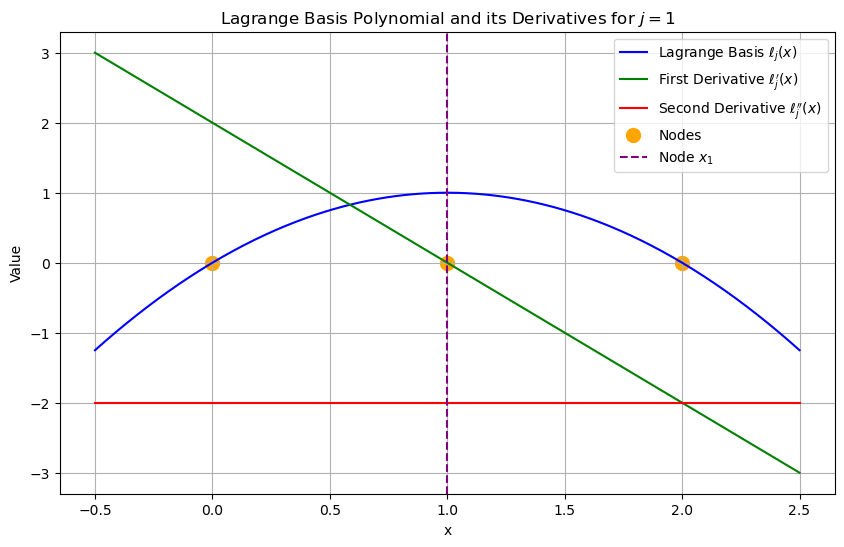

In [76]:
from jax import grad

def plot_lagrange_and_derivatives(x_nodes, j):
    x_vals = jnp.linspace(jnp.min(x_nodes) - 0.5, jnp.max(x_nodes) + 0.5, 400)

    # Compute the Lagrange basis polynomial and its derivatives
    lj_vals = jnp.array([lagrange_basis(x, x_nodes, j) for x in x_vals])

    x_test = 2.0
    test = lagrange_basis(x_test, x_nodes, j)
    print(test)
    
    # first derivative
    lj_prime = grad(lagrange_basis, argnums=0)
    display(lj_prime)
    
    lj_prime_vals = jnp.array([lj_prime(x, x_nodes, j) for x in x_vals])
    lj_prime_test = lj_prime(x_test, x_nodes, j)
    print(lj_prime_test)
    
    # second derivative
    lj_double_prime = grad(lj_prime, argnums=0)
    lj_double_prime_vals = jnp.array([lj_double_prime(x, x_nodes, j) for x in x_vals])

    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, lj_vals, label='Lagrange Basis $\\ell_j(x)$', color='blue')
    plt.plot(x_vals, lj_prime_vals, label='First Derivative $\\ell_j\'(x)$', color='green')
    plt.plot(x_vals, lj_double_prime_vals, label='Second Derivative $\\ell_j\'\'(x)$', color='red')
    plt.scatter(x_nodes, jnp.zeros_like(x_nodes), color='orange', s=100, label='Nodes')
    plt.axvline(x=x_nodes[j], color='purple', linestyle='--', label=f'Node $x_{j}$')
    
    plt.title(f"Lagrange Basis Polynomial and its Derivatives for $j={j}$")
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
x_nodes = jnp.array([0.0, 1.0, 2.0])
j = 1  # Index for which we want to plot the basis polynomial and its derivatives
plot_lagrange_and_derivatives(x_nodes, j)

In [82]:
from scipy.optimize import fsolve

def lagrange_basis(x, x_nodes, j):
    """Compute the j-th Lagrange basis polynomial at x, avoiding direct Python conditionals."""
    n = len(x_nodes)
    # Create a product of terms (x - x_m) / (x_j - x_m) for m != j
    terms = jnp.prod(jnp.where(jnp.arange(n) != j, (x - x_nodes) / (x_nodes[j] - x_nodes), 1))
    return terms

lagrange_derivative_2 = jit(grad(grad(lagrange_basis, argnums=0), argnums=0))

In [83]:
# Collocation points
x_nodes = jnp.array([0, np.pi/2, np.pi])

# Function representing the system of equations to solve
def collocation_system(coeffs):
    # Unpack coefficients
    n = len(coeffs)
    u = lambda x: sum([coeffs[j] * lagrange_basis(x, x_nodes, j) for j in range(n)])
    du_double = lambda x: sum([coeffs[j] * lagrange_derivative_2(x, x_nodes, j) for j in range(n)])

    equations = [du_double(x_nodes[i]) + u(x_nodes[i]) for i in range(1, n-1)]  # Internal points
    # Boundary conditions
    equations = [u(x_nodes[0])] + equations + [u(x_nodes[-1])]
    return np.array(equations)

# Initial guess for coefficients
coeffs_initial = np.zeros(len(x_nodes))

# Solve the system
coeffs_solution = fsolve(collocation_system, coeffs_initial)

print("Solution coefficients:", coeffs_solution)


Solution coefficients: [0. 0. 0.]


/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_99660/1846281809.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  coeffs_solution = fsolve(collocation_system, coeffs_initial)


In [126]:
@jit
def second_derivative(t, coeffs, x_nodes):
    basis_derivatives = grad(grad(lagrange_basis, argnums=0), argnums=0)
    return sum(coeffs[i] * basis_derivatives(t, x_nodes, i) for i in range(len(coeffs)))

eq1 0.0
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------
eq1 0.0
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------
eq1 0.0
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------
eq1 1.4901161e-08
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------
eq1 0.0
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------
eq1 0.0
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------
eq1 0.0
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------
eq1 0.0
eq2 -1.0
second_derivative nan
collocation_eqs nan
-------


/Users/mariiashapo/anaconda3/envs/jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/Users/mariiashapo/anaconda3/envs/jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/Users/mariiashapo/ana

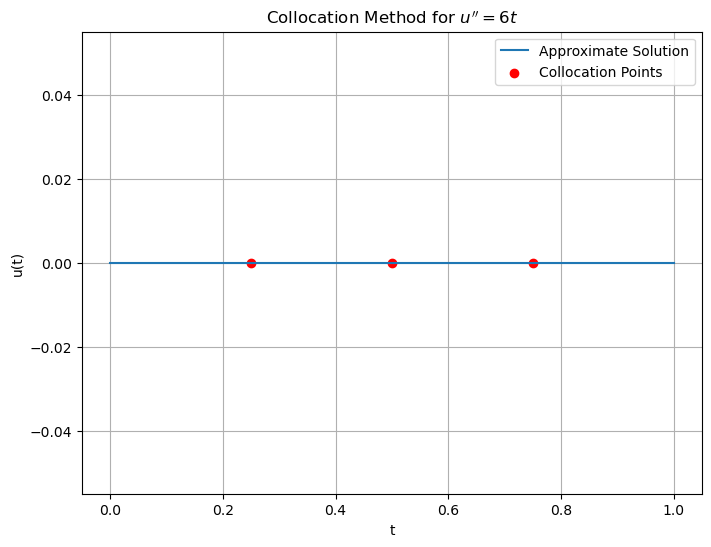

In [125]:
def collocation(f, t_bounds, y_bounds, collocation_points):
    t0, t1 = t_bounds
    y0, y1 = y_bounds
    x_nodes = jnp.array([t0, *collocation_points, t1])
    n = len(x_nodes) - 2  

    def equations(coeffs):
        u = lambda t: sum(coeffs[i] * lagrange_basis(t, x_nodes, i) for i in range(len(coeffs)))
        eq1 = u(t0) - y0
        eq2 = u(t1) - y1
        print("eq1", eq1)
        print("eq2", eq2)
        print("second_derivative", second_derivative(1.2, coeffs, x_nodes))
        collocation_eqs = [second_derivative(t, coeffs, x_nodes) - f(t) for t in collocation_points]
        print("collocation_eqs", collocation_eqs[0])
        print("-------")
        eq = jnp.concatenate([jnp.array([eq1, eq2]), jnp.array(collocation_eqs)])
        return eq

    initial_guess = np.zeros(len(x_nodes))
    solution = root(lambda coeffs: equations(coeffs).astype(np.float64), initial_guess, method='lm')

    if not solution.success:
        raise RuntimeError("Root finding did not converge")
    
    coeffs = solution.x
    
    return lambda t: sum(coeffs[i] * lagrange_basis(t, x_nodes, i) for i in range(len(coeffs)))

# Define the differential equation function
def f(t):
    return 6 * t

# Define parameters for collocation
t_bounds = (0, 1)
y_bounds = (0, 1)
collocation_points = np.array([0.25, 0.5, 0.75])

# Solve the ODE
u = collocation(f, t_bounds, y_bounds, collocation_points)

# Plotting
t_vals = np.linspace(0, 1, 100)
u_vals = vmap(u)(t_vals)

plt.figure(figsize=(8, 6))
plt.plot(t_vals, u_vals, label='Approximate Solution')
plt.scatter(collocation_points, vmap(u)(collocation_points), color='red', label='Collocation Points')
plt.title('Collocation Method for $u\'\' = 6t$')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()


### Barycentric form

In [346]:
import jax.numpy as jnp

def barycentric_weights(x):
    """
    Compute the barycentric weights for the given set of collocation points.
    
    Parameters:
    x (jax.numpy.ndarray): Array of collocation points of shape (n,).
    
    Returns:
    jax.numpy.ndarray: Array of barycentric weights of shape (n,).
    """
    n = x.shape[0]
    w = jnp.ones(n)
    for j in range(n):
        for k in range(n):
            if k != j:
                w = w.at[j].set(w[j] / (x[j] - x[k]))
    return w

def lagrange_basis(x, x_eval):
    """
    Compute the Lagrange basis polynomials in barycentric form at the evaluation points.
    
    Parameters:
    x (jax.numpy.ndarray): Array of collocation points of shape (n,).
    x_eval (jax.numpy.ndarray): Array of evaluation points of shape (m,).
    
    Returns:
    jax.numpy.ndarray: Matrix of shape (m, n) where each entry (i, j) is the 
                       value of the j-th Lagrange basis polynomial at the i-th evaluation point.
    """
    w = barycentric_weights(x)
    n = x.shape[0]
    m = x_eval.shape[0]
    
    # Initialize the result matrix
    L = jnp.zeros((m, n))
    
    for i in range(m):
        # Compute the numerator and denominator of the barycentric formula
        numerator = w / (x_eval[i] - x)
        denominator = jnp.sum(numerator)
        
        # The j-th Lagrange basis polynomial evaluated at x_eval[i]
        L = L.at[i, :].set(numerator / denominator)
    
    return L


In [347]:
def barycentric_weights(x):
    n = len(x)
    w = jnp.ones(n)
    for j in range(n):
        for k in range(n):
            if j != k:
                w = w.at[j].set(w[j] / (x[j] - x[k]))
    return w

def first_derivative_matrix(x, w):
    n = len(x)
    D1 = jnp.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                D1 = D1.at[i, j].set(w[j] / w[i] / (x[i] - x[j]))
        D1 = D1.at[i, i].set(-jnp.sum(D1[i, jnp.arange(n) != i]))
    return D1

def second_derivative_matrix(x, w, D1):
    n = len(x)
    D2 = jnp.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                D2 = D2.at[i, j].set(2 / (x[i] - x[j]) * (w[j] / w[i] * D1[i, i] - D1[i, j]))
        D2 = D2.at[i, i].set(-jnp.sum(D2[i, jnp.arange(n) != i]))
    return D2

# Example usage
x = jnp.array([0.0, 1.0, 2.0, 3.0])  # Example nodes
w = barycentric_weights(x)
D1 = first_derivative_matrix(x, w)
D2 = second_derivative_matrix(x, w, D1)

print("First Derivative Matrix D1:")
print(D1)
print("\nSecond Derivative Matrix D2:")
print(D2)


First Derivative Matrix D1:
[[-1.8333334   3.         -1.5         0.33333334]
 [-0.33333334 -0.49999994  1.         -0.16666667]
 [ 0.16666667 -1.          0.49999997  0.33333334]
 [-0.33333334  1.5        -3.          1.8333334 ]]

Second Derivative Matrix D2:
[[ 2.0000000e+00 -5.0000000e+00  4.0000000e+00 -1.0000000e+00]
 [ 1.0000000e+00 -2.0000000e+00  1.0000001e+00 -1.4901161e-08]
 [-1.4901161e-08  1.0000000e+00 -2.0000000e+00  1.0000000e+00]
 [-1.0000000e+00  4.0000000e+00 -5.0000000e+00  2.0000000e+00]]


In [350]:
# eg: Van der Pol Oscillator
def vdp_oscillator(y, t, mu=1.0):
    X, Y = y
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X
    return jnp.array([dXdt, dYdt])

Solution Coefficients:
X: [ 2.         -0.74554883 -0.64082908 -1.27694611  1.54303612  0.37037727
  2.14008297]
Y: [ 7.88583918e-34 -2.24290837e-01 -1.09152235e-01 -2.14218335e+00
 -8.65726544e-01 -2.04174984e+00  1.55837826e-02]


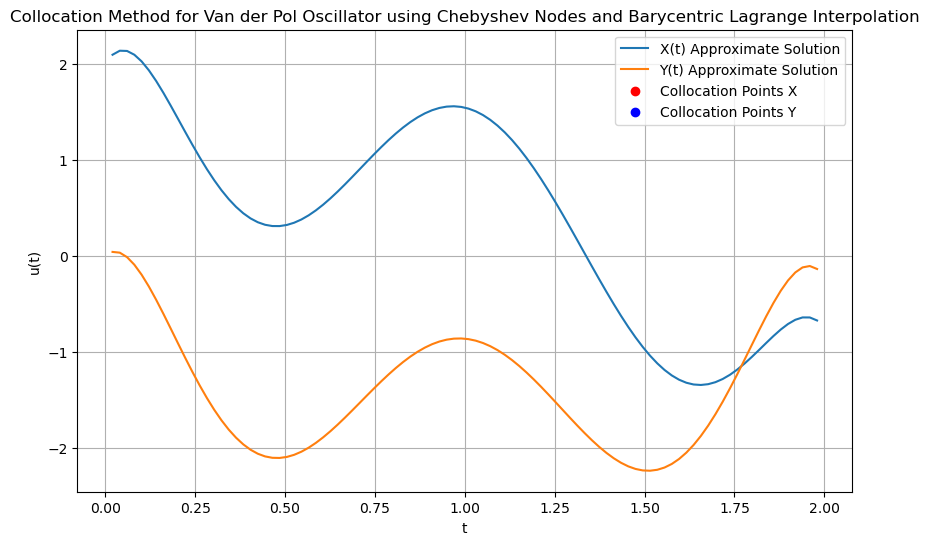

In [351]:
def collocation_system(ode_func, t_bounds, y_bounds, collocation_points, mu):
    t0, t1 = t_bounds
    y0, y1 = y_bounds
    n = len(collocation_points)
    
    x = jnp.concatenate((jnp.array([t0, t1]), jnp.array(collocation_points)))
    w = barycentric_weights(x)
    D1 = first_derivative_matrix(x, w)

    def equations(coeffs):
        Y = coeffs.reshape(2, -1)
        eqs = jnp.zeros((2, n + 2))
        
        # Boundary conditions
        eqs = eqs.at[0, 0].set(Y[0, 0] - y0[0])  # X(t0) = y0[0]
        eqs = eqs.at[1, 0].set(Y[1, 0] - y0[1])  # Y(t0) = y0[1]
        # eqs = eqs.at[0, 1].set(Y[0, 1] - y1[0])  # X(t1) = y1[0]
        # eqs = eqs.at[1, 1].set(Y[1, 1] - y1[1])  # Y(t1) = y1[1]
        
        # Collocation conditions
        for i in range(2, n + 2):
            t = x[i]
            dYdt = jnp.dot(D1[i], Y.T)
            dydt = ode_func(Y[:, i], t, mu)
            eqs = eqs.at[0, i].set(dYdt[0] - dydt[0])
            eqs = eqs.at[1, i].set(dYdt[1] - dydt[1])
        
        return eqs.flatten()

    initial_guess = jnp.zeros((2, n + 2))
    
    solution = root(lambda coeffs: jax.device_put(equations(coeffs)), initial_guess.flatten())
    
    if not solution.success:
        raise RuntimeError("Root finding did not converge")
    
    Y = solution.x.reshape(2, -1)
    
    def interpolate(t):
        numerator_x = jnp.sum(w * Y[0] / (t - x))
        denominator_x = jnp.sum(w / (t - x))
        x_t = numerator_x / denominator_x
        
        numerator_y = jnp.sum(w * Y[1] / (t - x))
        denominator_y = jnp.sum(w / (t - x))
        y_t = numerator_y / denominator_y
        
        return jnp.array([x_t, y_t])

    print(f"Solution Coefficients:\nX: {Y[0]}\nY: {Y[1]}")
    return interpolate

# ODE parameters
mu = 1.0

# Boundary values for t and y
t_bounds = (0, 2)
y_bounds = ([2, 0], [0, 0])

# Number of collocation points
num_collocation_points = 5

# Collocation points using Chebyshev nodes
collocation_points = chebyshev_nodes(t_bounds[0], t_bounds[1], num_collocation_points)

# Solve
interpolator = collocation_system(vdp_oscillator, t_bounds, y_bounds, collocation_points, mu)

# Evaluate
t_vals = jnp.linspace(0, 2, 100)
u_vals = jax.vmap(interpolator)(t_vals)

plt.figure(figsize=(10, 6))
plt.plot(t_vals, u_vals[:, 0], label='X(t) Approximate Solution')
plt.plot(t_vals, u_vals[:, 1], label='Y(t) Approximate Solution')
plt.scatter(collocation_points, jax.vmap(interpolator)(jnp.array(collocation_points))[:, 0], color='red', label='Collocation Points X')
plt.scatter(collocation_points, jax.vmap(interpolator)(jnp.array(collocation_points))[:, 1], color='blue', label='Collocation Points Y')
plt.title('Collocation Method for Van der Pol Oscillator using Chebyshev Nodes and Barycentric Lagrange Interpolation')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()


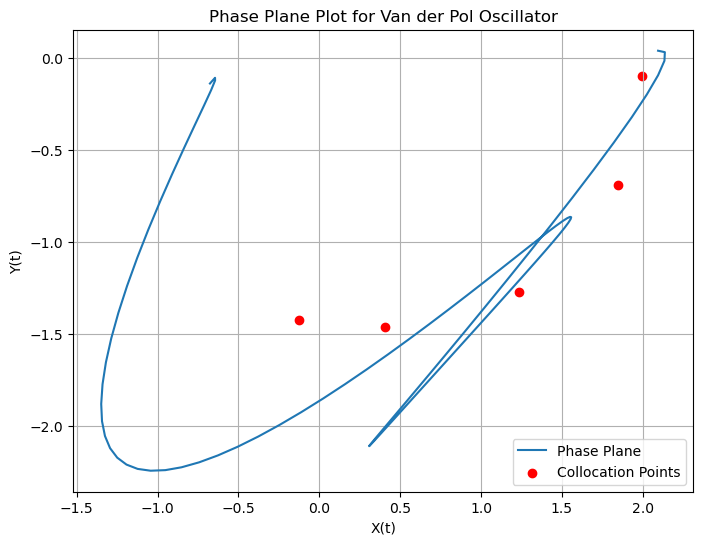

In [352]:
plt.figure(figsize=(8, 6))
plt.plot(u_vals[:, 0], u_vals[:, 1], label='Phase Plane')
plt.scatter(vmap(u1)(collocation_points), vmap(u2)(collocation_points), color='red', label='Collocation Points')
plt.title('Phase Plane Plot for Van der Pol Oscillator')
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.legend()
plt.grid(True)
plt.show()

Solution Coefficients:
X: [ 1.99999997e+00  4.97576417e-18 -5.72220143e-01  5.62569320e+00
 -6.13859658e+00  1.00277881e+01 -8.98426277e+00  1.09976361e+01
 -8.01070095e+00  8.15042639e+00 -3.59185456e+00  2.56947453e+00]
Y: [-6.26442179e-16  1.87996514e-16  6.90514199e-03 -1.92317721e-01
  1.98745754e-01 -1.09416655e-01  1.16349519e-01 -8.97246679e-02
  1.14498067e-01 -1.03408969e-01  1.58112794e-01 -5.08510211e-02]


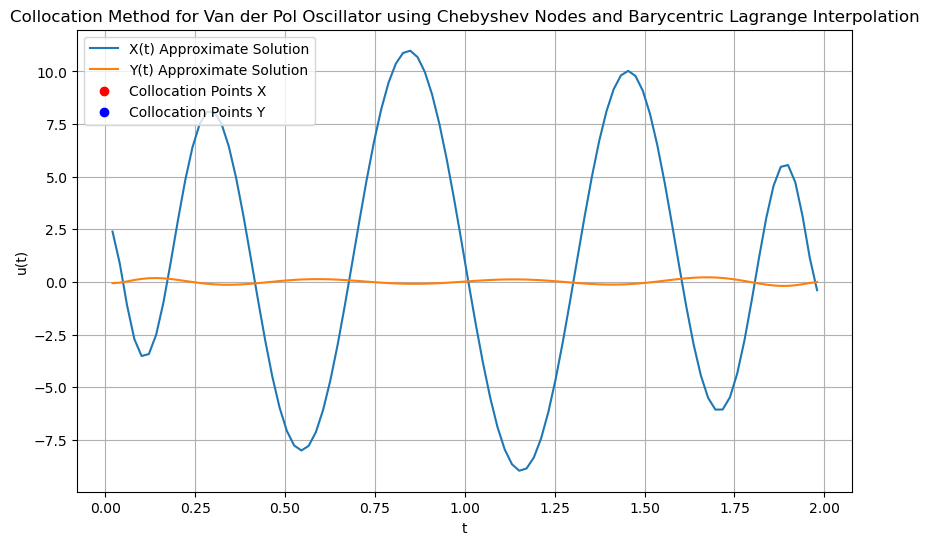

In [353]:
def collocation_system(ode_func, t_bounds, y_bounds, collocation_points, mu):
    t0, t1 = t_bounds
    y0, y1 = y_bounds
    n = len(collocation_points)
    
    x = jnp.concatenate((jnp.array([t0, t1]), jnp.array(collocation_points)))
    w = barycentric_weights(x)
    D1 = first_derivative_matrix(x, w)
    D2 = second_derivative_matrix(x, w, D1)

    def equations(coeffs):
        Y = coeffs.reshape(2, -1)
        eqs = jnp.zeros((2, n + 2))
        
        # Boundary conditions
        eqs = eqs.at[0, 0].set(Y[0, 0] - y0[0])  # X(t0) = y0[0]
        eqs = eqs.at[1, 0].set(Y[1, 0] - y0[1])  # Y(t0) = y0[1]
        eqs = eqs.at[0, 1].set(Y[0, 1] - y1[0])  # X(t1) = y1[0]
        eqs = eqs.at[1, 1].set(Y[1, 1] - y1[1])  # Y(t1) = y1[1]
        
        # Collocation conditions
        for i in range(2, n + 2):
            t = x[i]
            dYdt = jnp.dot(D1[i], Y.T)
            dydt = ode_func(Y[:, i], t, mu)
            eqs = eqs.at[0, i].set(dYdt[0] - dydt[0])
            eqs = eqs.at[1, i].set(dYdt[1] - dydt[1])
        
        return eqs.flatten()

    initial_guess = jnp.zeros((2, n + 2))
    
    solution = root(lambda coeffs: jax.device_put(equations(coeffs)), initial_guess.flatten())
    
    if not solution.success:
        raise RuntimeError("Root finding did not converge")
    
    Y = solution.x.reshape(2, -1)
    
    def interpolate(t):
        numerator_x = jnp.sum(w * Y[0] / (t - x))
        denominator_x = jnp.sum(w / (t - x))
        x_t = numerator_x / denominator_x
        
        numerator_y = jnp.sum(w * Y[1] / (t - x))
        denominator_y = jnp.sum(w / (t - x))
        y_t = numerator_y / denominator_y
        
        return jnp.array([x_t, y_t])

    print(f"Solution Coefficients:\nX: {Y[0]}\nY: {Y[1]}")
    return interpolate

# ODE parameters
mu = 1.0

# Boundary values for t and y
t_bounds = (0, 2)
y_bounds = ([2, 0], [0, 0])

# Number of collocation points
num_collocation_points = 10

# Collocation points using Chebyshev nodes
collocation_points = chebyshev_nodes(t_bounds[0], t_bounds[1], num_collocation_points)

# Solve
interpolator = collocation_system(vdp_oscillator, t_bounds, y_bounds, collocation_points, mu)

# Evaluate
t_vals = jnp.linspace(0, 2, 100)
u_vals = jax.vmap(interpolator)(t_vals)

plt.figure(figsize=(10, 6))
plt.plot(t_vals, u_vals[:, 0], label='X(t) Approximate Solution')
plt.plot(t_vals, u_vals[:, 1], label='Y(t) Approximate Solution')
plt.scatter(collocation_points, jax.vmap(interpolator)(jnp.array(collocation_points))[:, 0], color='red', label='Collocation Points X')
plt.scatter(collocation_points, jax.vmap(interpolator)(jnp.array(collocation_points))[:, 1], color='blue', label='Collocation Points Y')
plt.title('Collocation Method for Van der Pol Oscillator using Chebyshev Nodes and Barycentric Lagrange Interpolation')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()


Solution Coefficients:
X: [ 1.76205559 -0.57167896 -0.0308145  -0.37862661  0.17984042 -0.03567593
  0.54301655  0.45614981  1.00629488 -0.19620372]
Y: [ 0.04150295  0.29436171  0.42835255  0.55930794  0.77282356  0.87376029
  1.11357739  1.06050586  1.17494814 -0.08744966]


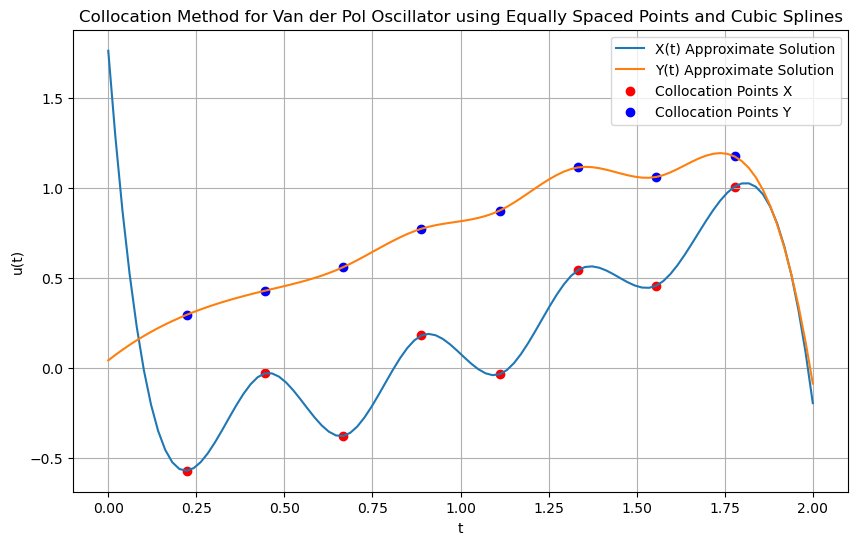

In [340]:
import numpy as np
from scipy.optimize import root
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def vdp_oscillator(y, t, mu):
    y1, y2 = y
    dydt = np.array([y2, mu * (1 - y1**2) * y2 - y1])
    return dydt

def collocation_splines(ode_func, t_bounds, y_bounds, collocation_points, mu):
    t0, t1 = t_bounds
    y0, y1 = y_bounds
    n = len(collocation_points)

    x = np.concatenate(([t0], collocation_points, [t1]))

    def equations(coeffs):
        y1_coeffs = coeffs[:n + 2]
        y2_coeffs = coeffs[n + 2:]

        spline_y1 = CubicSpline(x, y1_coeffs)
        spline_y2 = CubicSpline(x, y2_coeffs)

        eqs = np.zeros((2, n + 2))

        # Boundary conditions
        eqs[0, 0] = spline_y1(t0) - y0[0]
        eqs[1, 0] = spline_y2(t0) - y0[1]
        eqs[0, 1] = spline_y1(t1) - y1[0]
        eqs[1, 1] = spline_y2(t1) - y1[1]

        # Collocation conditions
        for i, t in enumerate(collocation_points):
            dYdt = np.array([spline_y1(t, 1), spline_y2(t, 1)])
            dydt = ode_func([spline_y1(t), spline_y2(t)], t, mu)
            eqs[0, i + 2] = dYdt[0] - dydt[0]
            eqs[1, i + 2] = dYdt[1] - dydt[1]

        return eqs.flatten()

    initial_guess = np.zeros(2 * (n + 2))

    solution = root(equations, initial_guess, method='lm')

    if not solution.success:
        raise RuntimeError("Root finding did not converge")

    y1_coeffs = solution.x[:n + 2]
    y2_coeffs = solution.x[n + 2:]

    spline_y1 = CubicSpline(x, y1_coeffs)
    spline_y2 = CubicSpline(x, y2_coeffs)

    def interpolate(t):
        return np.array([spline_y1(t), spline_y2(t)])

    print(f"Solution Coefficients:\nX: {y1_coeffs}\nY: {y2_coeffs}")
    return interpolate

# ODE parameters
mu = 1.0

# Boundary values for t and y
t_bounds = (0, 2)
y_bounds = ([2, 0], [0, 0])

# Number of collocation points
num_collocation_points = 10

# Collocation points using equally spaced points
collocation_points = np.linspace(t_bounds[0], t_bounds[1], num_collocation_points)[1:-1]

# Solve
interpolator = collocation_splines(vdp_oscillator, t_bounds, y_bounds, collocation_points, mu)

# Evaluate
t_vals = np.linspace(0, 2, 100)
u_vals = np.array([interpolator(t) for t in t_vals])

plt.figure(figsize=(10, 6))
plt.plot(t_vals, u_vals[:, 0], label='X(t) Approximate Solution')
plt.plot(t_vals, u_vals[:, 1], label='Y(t) Approximate Solution')
plt.scatter(collocation_points, np.array([interpolator(t) for t in collocation_points])[:, 0], color='red', label='Collocation Points X')
plt.scatter(collocation_points, np.array([interpolator(t) for t in collocation_points])[:, 1], color='blue', label='Collocation Points Y')
plt.title('Collocation Method for Van der Pol Oscillator using Equally Spaced Points and Cubic Splines')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()


Solution Coefficients:
X: [ 2.         -0.19382956  0.2113785  -0.28425811 -0.06732833 -0.30410844
  0.13001264  0.58253907  1.05540574  0.57970943 -0.8679569  -2.00683483]
Y: [ 2.26872026e-23 -4.43208848e-02 -3.64233622e-03 -2.39523992e-01
  4.20057852e-02  5.99475933e-03  5.85240366e-01  5.78980572e-01
  1.52634593e-01 -1.19885677e+00 -1.70430425e+00 -5.06978390e-02]


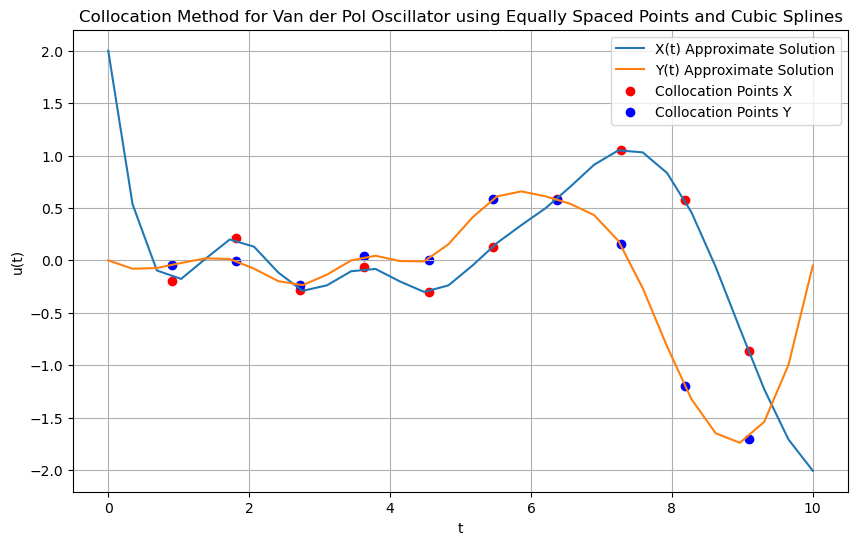

In [341]:
import numpy as np
from scipy.optimize import root
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def vdp_oscillator(t, y, mu):
    y1, y2 = y
    dydt = [y2, mu * (1 - y1**2) * y2 - y1]
    return dydt

def estimate_boundary(y0, t0, t1, mu):
    sol = solve_ivp(lambda t, y: vdp_oscillator(t, y, mu), [t0, t1], y0, method='RK45', t_eval=[t1])
    return sol.y[:, -1]

def collocation_splines(ode_func, t_bounds, y_bounds, collocation_points, mu):
    t0, t1 = t_bounds
    y0, y1 = y_bounds
    n = len(collocation_points)

    x = np.concatenate(([t0], collocation_points, [t1]))

    def equations(coeffs):
        y1_coeffs = coeffs[:n + 2]
        y2_coeffs = coeffs[n + 2:]

        spline_y1 = CubicSpline(x, y1_coeffs)
        spline_y2 = CubicSpline(x, y2_coeffs)

        eqs = np.zeros((2, n + 2))

        # Boundary conditions
        eqs[0, 0] = spline_y1(t0) - y0[0]
        eqs[1, 0] = spline_y2(t0) - y0[1]
        eqs[0, 1] = spline_y1(t1) - y1[0]
        eqs[1, 1] = spline_y2(t1) - y1[1]

        # Collocation conditions
        for i, t in enumerate(collocation_points):
            dYdt = np.array([spline_y1(t, 1), spline_y2(t, 1)])
            dydt = ode_func(t, [spline_y1(t), spline_y2(t)], mu)
            eqs[0, i + 2] = dYdt[0] - dydt[0]
            eqs[1, i + 2] = dYdt[1] - dydt[1]

        return eqs.flatten()

    initial_guess = np.zeros(2 * (n + 2))

    solution = root(equations, initial_guess, tol=1e-3, method='lm')

    if not solution.success:
        raise RuntimeError("Root finding did not converge")

    y1_coeffs = solution.x[:n + 2]
    y2_coeffs = solution.x[n + 2:]

    spline_y1 = CubicSpline(x, y1_coeffs)
    spline_y2 = CubicSpline(x, y2_coeffs)

    def interpolate(t):
        return np.array([spline_y1(t), spline_y2(t)])

    print(f"Solution Coefficients:\nX: {y1_coeffs}\nY: {y2_coeffs}")
    return interpolate

# ODE parameters
mu = 1.0

# Boundary values for t and y
t_bounds = (0, 10)
y0 = [2, 0]

# Estimate the boundary value at t1 using an ODE solver
y1 = estimate_boundary(y0, t_bounds[0], t_bounds[1], mu)

# Number of collocation points
num_collocation_points = 10

# Collocation points using equally spaced points
collocation_points = np.linspace(t_bounds[0], t_bounds[1], num_collocation_points + 2)[1:-1]

# Solve
interpolator = collocation_splines(vdp_oscillator, t_bounds, [y0, y1], collocation_points, mu)

# Evaluate
t_vals = np.linspace(0, 10, 30)
u_vals = np.array([interpolator(t) for t in t_vals])

plt.figure(figsize=(10, 6))
plt.plot(t_vals, u_vals[:, 0], label='X(t) Approximate Solution')
plt.plot(t_vals, u_vals[:, 1], label='Y(t) Approximate Solution')
plt.scatter(collocation_points, np.array([interpolator(t) for t in collocation_points])[:, 0], color='red', label='Collocation Points X')
plt.scatter(collocation_points, np.array([interpolator(t) for t in collocation_points])[:, 1], color='blue', label='Collocation Points Y')
plt.title('Collocation Method for Van der Pol Oscillator using Equally Spaced Points and Cubic Splines')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()
